# **2110443 - Computer Vision (2022/2)**
#**Lab 8 - Convolutional Neural Network [Homework]** <br>
In this lab, we will learn how to use Convolutional Neural Network to perform image classification in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer.

**Collaboration is encouraged in this course.** You must turn in your own write ups of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- Taechit Phowthongbutr 6231324921
- ...


# Assignment 1 : Food Image Classification
![alt text](https://cdn.pixabay.com/photo/2015/08/26/10/58/the-pork-fried-rice-made-908333_1280.jpg)

Classify 50 food menus from Chula-Food-50 dataset
 

In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 2 sets of data: train and test 

By using the knowledge from the lab and lecture, you have to design your own CNN food image classification model and tested on unknown label dataset!



Scoreboard URL : https://www.piclab.ai/classes/cv2022/lab8/scoreboard

In [ ]:
import random
import glob
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import font_manager

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder, DatasetFolder, VisionDataset
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

##### Add Thai font ######

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
font_manager.fontManager.addfont(path= 'thsarabunnew-webfont.ttf')
matplotlib.rc('font', family='TH Sarabun New')

##### Don't forget to put your ID here (in integer) ####
YOUR_STUDENT_ID_WITH21 = 6230314421 
#######################################################

def isStudentIDValid(studentID):
  strID = str(studentID)
  isEndWith21 = strID.endswith('21')
  isLengthOK = len(strID) == 10
  if isEndWith21 and isLengthOK:
    return True
  else:
    return False

print('Student ID status:',isStudentIDValid(YOUR_STUDENT_ID_WITH21))

--2023-03-21 04:08:46--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2023-03-21 04:08:46--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.3’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2023-03-21 04:08:46 (6.61 MB/s) - 

## Your model description goes here: ###
Using resnet50 with pretrained weights as a classifier model. <br>
We change the last layer (feedforward or linear) out_features as a num_classes to predict
For training process, we use <br>
criterion = nn.CrossEntropyLoss() <br>
optimizer = optim.SGD(foodNet.parameters(), lr=1e-3, momentum=0.9) <br>
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True) <br>
and num_epochs = 10

## GPU Status Check

In [ ]:
!nvidia-smi

Tue Mar 21 04:08:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and inspect Chula-Food-50 dataset

In [ ]:
!wget  -O chula-food-50.zip https://piclab.ai/classes/cv2021/Chula-food-50.zip
!unzip -qo chula-food-50.zip

In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
#### FILL Any Augmenetation HERE ####
transformTrain = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transformVal =  transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
### Load Dataset ###
foodTrainDataset = ImageFolder('./train/', transform=transformTrain)
print('train set length:', len(foodTrainDataset))

train set length: 20000


In [ ]:
### Split train and validation ###
TEST_SIZE = 0.1
SEED = 42
BATCH_SIZE = 16
# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(foodTrainDataset)),
    foodTrainDataset.targets,
    stratify=foodTrainDataset.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(foodTrainDataset, train_indices)
test_split = Subset(foodTrainDataset, test_indices)

## Dataset Visualization

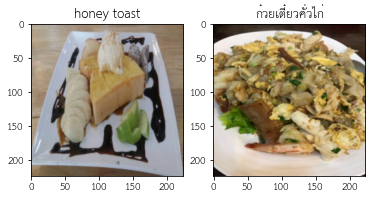

In [ ]:
image1, image1ClassName = getImageFromDataset(foodTrainDataset, 0)
image2, image2ClassName = getImageFromDataset(foodTrainDataset, 1600)

_, figure = plt.subplots(1,2)

figure[0].imshow(image1,cmap='gray')
figure[0].set_title(image1ClassName)
figure[1].imshow(image2,cmap='gray')
figure[1].set_title(image2ClassName)
plt.show()

## Define CNN network for food classification
Hint
1. You can freely uses any structure/pretrained model to do this homework but don't forgot to cited them in this notebook.

   A very big collection of pretrained model can be found here : https://github.com/rwightman/pytorch-image-models

2. Don't forget to change mean and std in the pre-processing to match with your pretrained model.

In [ ]:
#### Design you network here ####
class foodNet(nn.Module):
  def __init__(self):
    super(foodNet, self).__init__()
    ### Layers goes here ###
    self.backbone = models.resnet18(weights='IMAGENET1K_V1')

    # change the last layer (classifier layer) to predict custom num_classes
    self.num_feats = self.backbone.fc.in_features
    self.backbone.fc = nn.Linear(self.num_feats, 50)

  def forward(self, input):
    ### Conntections goes here ###
    x = self.backbone(input)
    return x
    
foodNet = foodNet()

In [ ]:
input = torch.zeros((16, 3, 224, 224), dtype=torch.float)
output = foodNet(input)
print(input.size(), output.size())

torch.Size([16, 3, 224, 224]) torch.Size([16, 50])


## Construct the model, optimizer and loss function

In [ ]:
#### FILL HERE ####
foodNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(foodNet.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

foodTrainDatasetLoader  = DataLoader(train_split, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
foodValDatasetLoader    = DataLoader(test_split , batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

## Train the model

In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols=100)
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )
    
      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer, scheduler, criterion, trainEpoch):
  
  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols=100):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols=100)
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)
    
      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)
    
      loss.backward()
      optimizer.step()
      

      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)
    
    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(foodTrainDatasetLoader, foodValDatasetLoader, 
                                                                    foodNet, optimizer, scheduler, criterion, 
                                                                    trainEpoch=10)

Overall Training Progress::   0%|                                            | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|                                                                      | 0/1125 [00:00<?, ?it/s]

  0%|                                                                       | 0/125 [00:00<?, ?it/s]

## Classify on validation set and send result to server!

In [ ]:
from PIL import Image
import json
import requests

class ImageFolderWithPaths(Dataset):
    def __init__(self, root_dir, transform=None):
        self.imageFileNames = sorted(glob.glob(root_dir+'/*.jpg'))
        self.transform = transform
    
    def __getitem__(self, idx):
        imageData = Image.open(self.imageFileNames[idx])
        imageFileName = os.path.basename(self.imageFileNames[idx])
        if self.transform is not None:
            imageData = self.transform(imageData)
        return imageFileName, imageData.unsqueeze(0)
    def __len__(self):
        return len(self.imageFileNames)



def generatePredictedResults(valDataset, net):
    net.eval()
    predictedResults = {}
    with torch.no_grad():
        for imageFileName, imageData in tqdm(valDataset, ncols=100):
            imageData = imageData.cuda()
            outputs = net(imageData)
            _, predicted = torch.max(outputs, 1)
            #print(imageFileName, predicted.item())
            predictedResults[imageFileName] =  foodTrainDataset.classes[predicted.item()]
    return predictedResults

def sendResult(predictedResults,studentID=5630008021):
    sendDict = { 'studentID':studentID, 'results':  predictedResults }
    response = requests.post('https://www.piclab.ai/classes/cv2022/lab8/scoreboard/submit',headers={'Content-Type': 'application/json' }, json=sendDict)
    return response.text

Example Result JSON <br>
resultDict = { 
  'studentID': 555555555521,
  'results':{
    '1.jpg':'ต้มเลือดหมู',
    '2.jpg':'บะหมี่แห้ง',
    ...
  }
}


In [ ]:
foodTestDataset = ImageFolderWithPaths('test', transform=transformVal)
predictedResults = generatePredictedResults(foodTestDataset, bestNet)
print(sendResult(predictedResults, studentID=YOUR_STUDENT_ID_WITH21))

  0%|                                                                      | 0/5000 [00:00<?, ?it/s]

{"accuracy":"83.28","status":"SUCCESS"}

